# <center> Power Controller </center>
<center> Josh Wilkins <br> 5/9/2017 </center>

In [1]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import control

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.0)

<img src="./Images/Analysis.png" height="800" width="600"/>
![](D:/_TinyHawk/Simulation/PowerController/Images/Analysis.png)

In [38]:
# Designing the Controller using the slowest response for Kr so that the settling time spec is always met
# Kr: Envelope Detector Gain [dBm/V]
# Ts: Settling time
# kf: VGA gain
def design_controller(kr, Ts=500e-6, kf=55):
    tau1 = (Ts/10)*(kr*kf**2) # /10 Factor to account for non-linearities (Usually ~5)
    tau = tau1/(kr*kf**2)
    Ts = 10*tau
    
    gol = kf**2 * control.tf([1],[tau1, 0])
    gcl = gol/(1+kr*gol)
    
    C = 1e-6
    R = tau1/C
    print 'R=%.1f Ohms \t C=%.1e uF' % (R, C)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.xlabel('Time (us)')
    plt.title('Slowest Response (Pin = -15dBm)')
    plt.grid(which='both')
    T, yout = control.step_response(gcl)
    plt.plot(T/(1e-6), yout)
    plt.axhline(y=0.993*(1/kr), color='r')
    
    return gol, gcl

# Illustrating fastest settling time using fastest response for Kr
# gol: Designed open loop response
def check_controller(kr, gol, kf=55):

    gcl = gol/(1+kr*gol)

    plt.subplot(1, 2, 2)
    plt.xlabel('Time (us)')
    plt.title('Fastest Response (Pin = +15dBm)')
    plt.grid(which='both')
    T, yout = control.step_response(gcl)
    plt.plot(T/(1e-6), yout)
    plt.axhline(y=0.993*(1/kr), color='r')
    plt.show()
    return gcl

# Bode plots of slowest and fastest responses
# gcl1: Closed loop function of slowest response
# gcl2: Closed loop function of fastest response
def bode_plot(gcl1, gcl2):
    plt.figure()
    plt.subplot(2,1,1)
    plt.title('Closed Loop Bode Plots')
    mag, phase, omega = control.bode([gcl1, gcl2], Hz=True, dB=True)
    plt.subplot(2,1,1)
    plt.legend(['Slowest Response', 'Fastest Response'])
    plt.show()

Due to long lead times of the ADL6010, an alternative envelope detector was used until the ADL6010 arrived. The LTC5564 had a similar response to the ADL6010, but could not be used due to its high temperature dependency. The same PI filter was used with little consequence, just a slower response, but worked well enough until the ADL6010 arrived.

### <center> ADL6010 </center>

From the ADL6010 Datasheet, Kr is given as a linear value in V/V. But in the V/dBm units needed, it is very nonlinear as shown below. Taking the derivative of the graph below, the value of kr in units of V/dBm can be approximated.

<img src="./Images/FindingKr.png"/>
![](D:/_TinyHawk/Simulation/PowerController/Images/FindingKr.png)

R=3833.9 Ohms 	 C=1.0e-06 uF


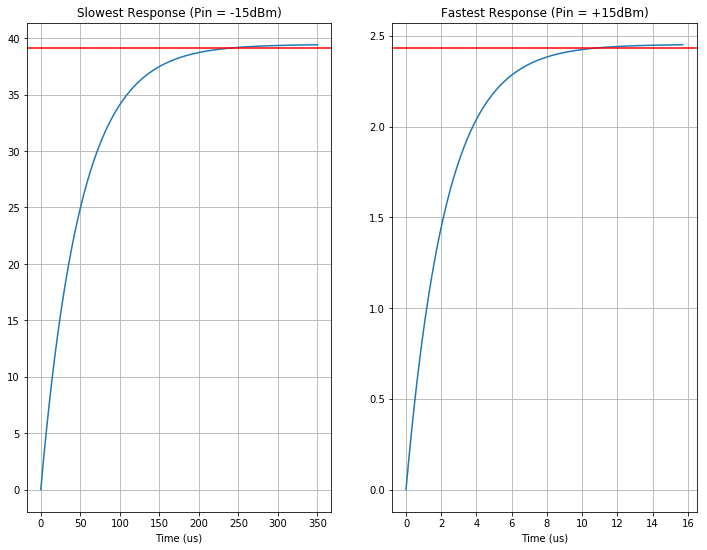

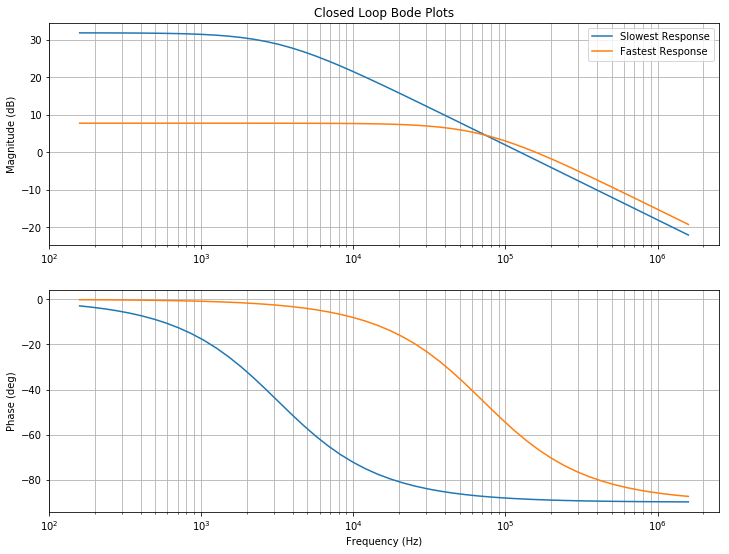

In [37]:
# ADL6010
Vin = -10
kr = 0.077*np.exp(0.11111*Vin) # Envelope Detector Gain [dBm/V]
gol, gcl1 = design_controller(kr)

Vin = 15
kr = 0.077*np.exp(0.11111*Vin) # Envelope Detector Gain [dBm/V]
gcl2 = check_controller(kr, g)

bode_plot(gcl1, gcl2)

### <center> LTC5564 </center>

Due to the long lead time of the From the ADL6010, the LTC5564 was also examined for use. It appears to have a similar response, however it looks like it will be unusable due to its temperature dependency. Again, using the data from the datasheet to estimate kr:

<img src="./Images/FindingKr_2.png"/>
![](D:/_TinyHawk/Simulation/PowerController/Images/FindingKr_2.png)

R=2767.0 Ohms 	 C=1.0e-06 uF


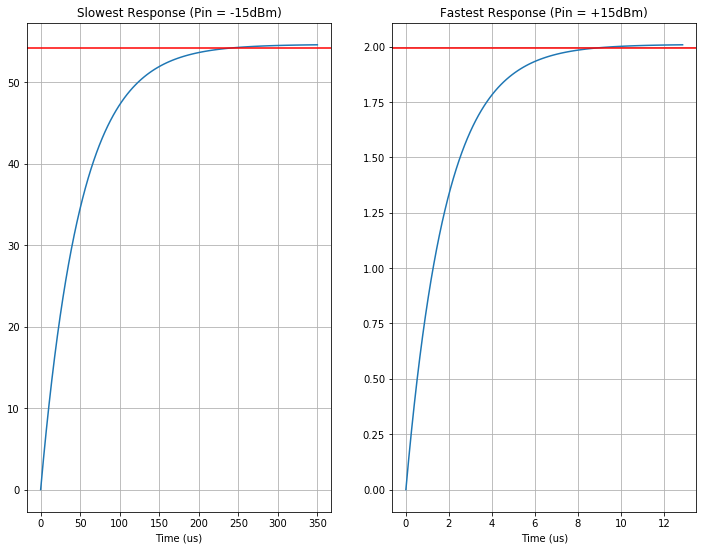

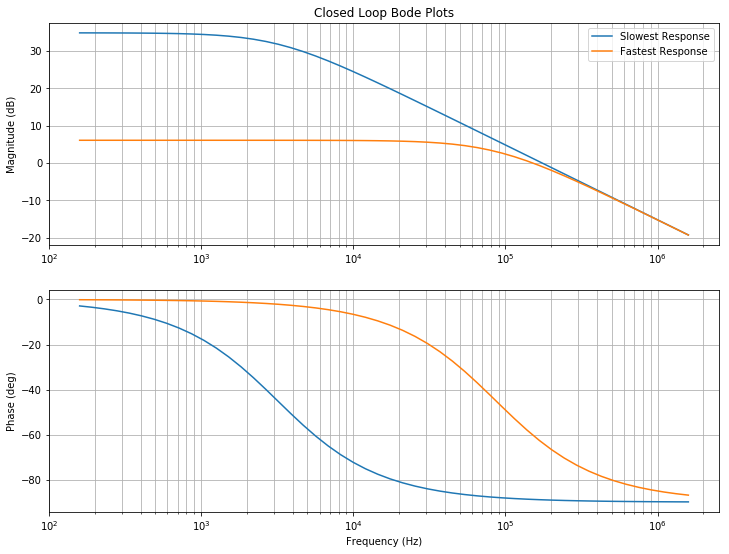

In [39]:
# LTC5564
Vin = -15
kr = 0.0954*np.exp(0.1101*Vin) # Envelope Detector Gain [dBm/V]
gol, gcl1 = design_controller(kr)

Vin = 15
kr = 0.0954*np.exp(0.1101*Vin) # Envelope Detector Gain [dBm/V]
gcl2 = check_controller(kr, gol)

bode_plot(gcl1, gcl2)